<h1>Wildfire Risk Prediction</h1>
<h3>CSE620 B - Computer Vision and Remote Sensing</h3>
<h5>Ryan Holthouse, Caleb Mostyn, Julia Loncala, Seth Peppo</h5>
<hr>

<h2>Imports</h2>

Import necessary libraries

In [53]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm  # Import tqdm for progress bar
from rasterio.transform import from_bounds
import xarray as xr

<h2>Data Digestion</h2>

Bringing in the data in a nc4 (NetCDF-4) file format

In [54]:
# Filename: WLDAS_NOAHMP001_DA1_20230206.D10.nc

# Open the file
# !!! REPLACE THIS PATH UPON DOWNLOADING OR CLONING !!!
data = xr.open_dataset('~/620proj/WLDAS_NOAHMP001_DA1_20230206.D10.nc')

# Ideally this will be in an API format. Presently downloading files manually

# Inspect the data
print(data)

<xarray.Dataset> Size: 2GB
Dimensions:                 (time: 1, lon: 3591, lat: 2787, bnds: 2)
Coordinates:
  * time                    (time) datetime64[ns] 8B 2023-02-06
  * lon                     (lon) float64 29kB -124.9 -124.9 ... -89.03 -89.03
  * lat                     (lat) float64 22kB 25.07 25.08 25.09 ... 52.92 52.92
Dimensions without coordinates: bnds
Data variables: (12/42)
    Swnet_tavg              (time, lat, lon) float32 40MB ...
    Lwnet_tavg              (time, lat, lon) float32 40MB ...
    Qle_tavg                (time, lat, lon) float32 40MB ...
    Qh_tavg                 (time, lat, lon) float32 40MB ...
    Qg_tavg                 (time, lat, lon) float32 40MB ...
    Snowf_tavg              (time, lat, lon) float32 40MB ...
    ...                      ...
    SoilTemp10_40cm_tavg    (time, lat, lon) float32 40MB ...
    SoilMoi40_100cm_tavg    (time, lat, lon) float32 40MB ...
    SoilTemp40_100cm_tavg   (time, lat, lon) float32 40MB ...
    SoilMoi100_

<hr>
<h3>Output all variable names to get more information</h3>

In [55]:
for var_name in data.data_vars:
    print(f"Variable: {var_name}")
    print(data[var_name])

Variable: Swnet_tavg
<xarray.DataArray 'Swnet_tavg' (time: 1, lat: 2787, lon: 3591)> Size: 40MB
[10008117 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-02-06
  * lon      (lon) float64 29kB -124.9 -124.9 -124.9 ... -89.04 -89.03 -89.03
  * lat      (lat) float64 22kB 25.07 25.08 25.09 25.1 ... 52.91 52.92 52.92
Attributes:
    standard_name:  surface_net_downward_shortwave_flux
    long_name:      net downward shortwave radiation
    units:          W m-2
    cell_methods:   time: mean
    vmax:           725.0
    vmin:           0.0
Variable: Lwnet_tavg
<xarray.DataArray 'Lwnet_tavg' (time: 1, lat: 2787, lon: 3591)> Size: 40MB
[10008117 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-02-06
  * lon      (lon) float64 29kB -124.9 -124.9 -124.9 ... -89.04 -89.03 -89.03
  * lat      (lat) float64 22kB 25.07 25.08 25.09 25.1 ... 52.91 52.92 52.92
Attributes:
    standard_name:  surface_net_downward_longwave_flux
    l

<hr>

<h2>Humidity Map</h2>

Printing the humidity data, stored in the data variable 'Qair_f_tavg'

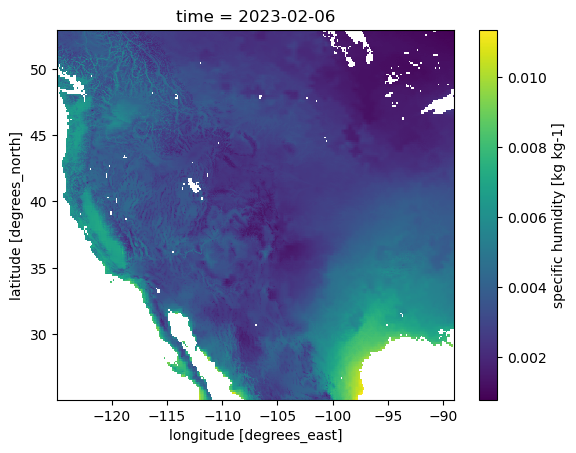

In [56]:
humidity_variable = data['Qair_f_tavg']     # Temperature variable

humidity_variable.plot()
plt.show()

<h2>Air Temperature Map</h2>

Printing the air temperature data, stored in the data variable 'Tair_f_tavg'.

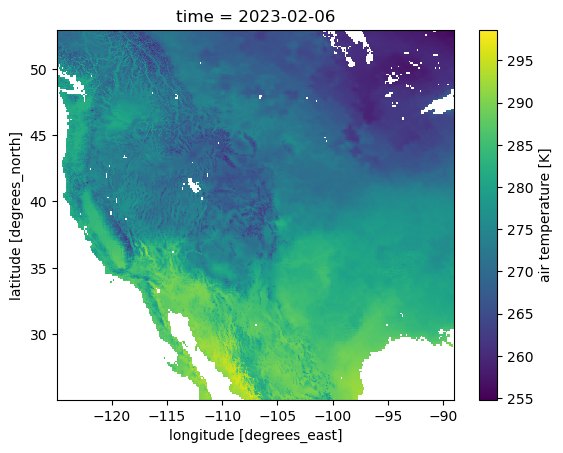

In [57]:
# Select a variable to plot
tempK_variable = data['Tair_f_tavg']     # Temperature variable

tempK_variable.plot()
plt.show()

<h2>Fahrenheit Conversion</h2>

Converting air temperature data from Kelvin to Fahrenheit and storing the new variable in 'fahrenheit'

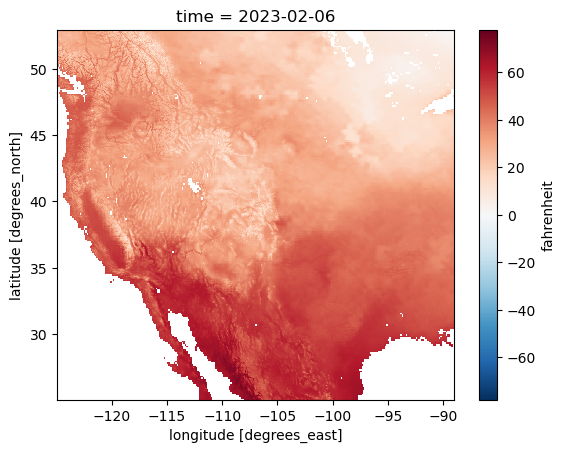

In [58]:
temperature_kelvin = data['Tair_f_tavg']
tmp_fheit = (temperature_kelvin - 273.15) * 9 / 5 + 32
data['fahrenheit'] = tmp_fheit

fehr_var = data['fahrenheit']

# Plot the data
fehr_var.plot()
plt.show()


<h2>Converting filetypes into a TIF</h2>

Changing the NC4 file into a tif with bands for air temperature and humidity, really just for easier manipulation and work

In [ ]:
# Select the variable to convert (e.g., 'temperature')
variable = data['fahrenheit']
# variable = data['Qair_f_tavg']

# Extract spatial dimensions and metadata
lat = variable['lat'].values  # Replace with your latitude dimension name
lon = variable['lon'].values  # Replace with your longitude dimension name
data_array = variable.values  # Data as a NumPy array

# Squeeze the data to remove extra dimensions
data_array = data_array.squeeze()

# Flip the data vertically to correct orientation
data_array = np.flipud(data_array)

# Get spatial bounds
lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()

# Create an affine transform (georeferencing)
transform = from_bounds(lon_min, lat_min, lon_max, lat_max, len(lon), len(lat))

# Set CRS (Coordinate Reference System)
crs = "EPSG:4326"  # WGS84 Latitude/Longitude

# Save as GeoTIFF, change this filename later
output_tif = "output_file.tif"
with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=data_array.shape[0],  # Number of rows (lat)
    width=data_array.shape[1],   # Number of columns (lon)
    count=1,  # Single band
    dtype=data_array.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(data_array, 1)  # Write data to the first band

print(f"GeoTIFF saved to {output_tif}")


GeoTIFF saved to output_file.tif


<h2>Opening and rendering TIF file</h2>

Opening the newly created TIF file and displaying it. Ensuring proper render of the new tif

GeoTIFF Metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 3591, 'height': 2787, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.009997215260373152, 0.0, -124.925,
       0.0, -0.009996411912450662, 52.925)}


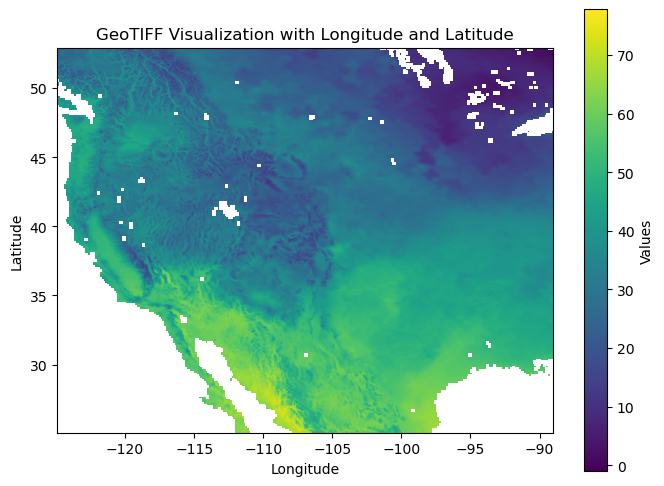

In [60]:
tif_file = "output_file.tif"

# Open the GeoTIFF file
with rasterio.open(tif_file) as src:
    # Read the first band
    data = src.read(1)  # Reading the first (and only) band
    transform = src.transform  # Affine transform
    metadata = src.meta  # Get metadata

# Print metadata
print("GeoTIFF Metadata:")
print(metadata)

# Create longitude and latitude arrays using the transform
rows, cols = data.shape
lon = np.linspace(transform[2], transform[2] + transform[0] * cols, cols)
lat = np.linspace(transform[5], transform[5] + transform[4] * rows, rows)

# Display the raster data
plt.figure(figsize=(8, 6))
plt.imshow(data, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap='viridis', origin="upper")
plt.colorbar(label='Values')
plt.title('GeoTIFF Visualization with Longitude and Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
